In [ ]:
#Run this on 'http://14pyg.abmi.kr/user/hihipch/lab?' server

In [37]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import shutil
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.optimizers import Adadelta
from keras.backend import get_session
from keras.preprocessing.image import ImageDataGenerator

In [37]:
# For frontXray
frontXray_path = '/home/hihipch/SkullSegmentation/image/front' 
frontXray_list = []
for (path, dir, files) in os.walk(frontXray_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            frontXray_list.append(filePath)

In [38]:
# For upXray
upXray_path = '/home/hihipch/SkullSegmentation/image/up' 
upXray_list = []
for (path, dir, files) in os.walk(upXray_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            upXray_list.append(filePath)

In [39]:
# For leftXray
leftXray_path = '/home/hihipch/SkullSegmentation/image/left' 
leftXray_list = []
for (path, dir, files) in os.walk(leftXray_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            leftXray_list.append(filePath)

In [40]:
# For rightXray
rightXray_path = '/home/hihipch/SkullSegmentation/image/right' 
rightXray_list = []
for (path, dir, files) in os.walk(rightXray_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            rightXray_list.append(filePath)

In [41]:
print(len(frontXray_list))
print(len(upXray_list))
print(len(leftXray_list))
print(len(rightXray_list))

181
181
181
181


In [42]:
### Create dataframe
# frontXray_list = 0
# upXray_list = 1
# leftXray_list = 2
# rightXray_list = 3


frontXray_df = pd.DataFrame(data={'filename': frontXray_list, 'label': [0 for i in range(len(frontXray_list))]})
upXray_df = pd.DataFrame(data={'filename': upXray_list, 'label': [1 for i in range(len(upXray_list))]})
leftXray_df = pd.DataFrame(data={'filename': leftXray_list, 'label': [2 for i in range(len(leftXray_list))]})
rightXray_df = pd.DataFrame(data={'filename': rightXray_list, 'label': [3 for i in range(len(rightXray_list))]})

df=frontXray_df.append([upXray_df, leftXray_df, rightXray_df])
df.columns=['filename', 'label']
df=df.sample(frac=1)
df.reset_index(drop=True,inplace=True)

In [43]:
### One hot encoding of label
y_train = np.array(df['label'].tolist())
y_train = keras.utils.np_utils.to_categorical(y_train)

In [15]:
metadata=[]
for i in df['filename'].values:
    metadata.append(pydicom.filereader.dcmread(str(i)))

In [19]:
metadata[1].pixel_array

array([[ 681,  669,  652, ...,  674,   21,    0],
       [ 675,  660,  649, ...,  676,   27,    0],
       [ 700,  673,  654, ...,  668,   26,    0],
       ...,
       [ 614,  603,  616, ..., 1840,   36,    0],
       [ 580,  570,  583, ..., 1798,  140,    0],
       [  30,   19,   32, ...,    0,    1,    0]], dtype=uint16)

In [11]:
# ### Resizing DICOM files in the df
# x_train=[]
# for i in metadata:
#     i=i.pixel_array
#     i=cv2.resize(i, (256, 256))
#     x_train.append(i)
# x_train=np.array(x_train)

In [21]:
x_train=[]
for i in metadata:
    pixeldata=i.pixel_array
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(pixeldata)
    cl1 = cv2.resize(cl1, (224, 224))
    backtorgb = cv2.cvtColor(cl1,cv2.COLOR_GRAY2RGB)
    mean, std = backtorgb.mean(), backtorgb.std()
    x_train.append((np.clip((backtorgb-mean)/std, -2.0, 2.0)+2.0)/4.0)    

In [13]:
# regularized=[]
# for i in range(len(x_train)):
#     mean, std = x_train[i].mean(), x_train[i].std()
#     regularized.append((np.clip((x_train[i]-mean)/std, -2.0, 2.0)+2.0)/4.0)

In [22]:
overlayData=[]
for image in metadata:
    overlay_data=image[0x6000, 0x3000].value
    rows = image[0x6000, 0x0010].value
    cols = image[0x6000, 0x0011].value
    btmp = np.frombuffer(overlay_data, dtype=np.uint8)
    btmp = np.unpackbits(btmp)
    btmp = btmp[:rows*cols]
    btmp = np.reshape(btmp, (rows, cols))
    btmp = cv2.resize(btmp, (224, 224))
    btmp = cv2.cvtColor(btmp,cv2.COLOR_GRAY2RGB)
    overlayData.append(btmp)
overlayData=np.array(overlayData)

In [23]:
blendedImage=[]
for i in range(len(overlayData)):
    blendedImage.append(np.maximum(x_train[i], overlayData[i]))

(724, 224, 224, 3)

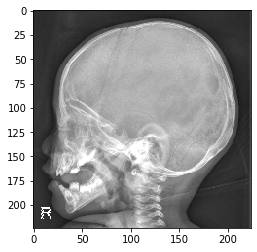

In [24]:
plt.imshow(blendedImage[126])
np.array(blendedImage).shape

In [16]:
# blendedImage=np.array(blendedImage).reshape(724, 256, 256, 1).astype('float32')

In [70]:
x_val=blendedImage[570:650]
y_val=y_train[570:650]
x_test=blendedImage[650:]
y_test=y_train[650:]

In [71]:
blendedImage=blendedImage[:570]
y_train=y_train[:570]

In [25]:
#resnet50
num_classes=2
input_shape=(224, 224, 3)
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation, Concatenate, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adadelta, SGD, Nadam
front_model = ResNet50(include_top=False,
                            weights='imagenet',
                            input_shape=input_shape, pooling='avg')

In [26]:
front_model.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [31]:
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation, Concatenate, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adadelta, SGD, Nadam

#resnet50
num_classes=4
input_shape=(224, 224, 3)

front_model = ResNet50(include_top=False,
                            weights='imagenet',
                            input_shape=input_shape, pooling='avg')

x = Dense(num_classes, activation='softmax', name='predictions')(front_model.output)
front_model = Model([front_model.input], x)
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
front_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
front_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [32]:
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=15)
hist = front_model.fit(np.array(blendedImage), y_train, epochs=50, callbacks=[cb_early_stopping], batch_size=4,  validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 579 samples, validate on 145 samples
Epoch 1/50
579/579 [==============================] - 44s 76ms/step - loss: 0.2763 - accuracy: 0.8864 - val_loss: 0.8171 - val_accuracy: 0.6552
Epoch 2/50
579/579 [==============================] - 20s 34ms/step - loss: 0.0690 - accuracy: 0.9823 - val_loss: 0.9523 - val_accuracy: 0.6552
Epoch 3/50
579/579 [==============================] - 20s 34ms/step - loss: 0.0317 - accuracy: 0.9918 - val_loss: 1.0716 - val_accuracy: 0.6552
Epoch 4/50
579/579 [==============================] - 20s 34ms/step - loss: 0.0214 - accuracy: 0.9957 - val_loss: 0.8378 - val_accuracy: 0.6690
Epoch 5/50
579/579 [==============================] - 20s 34ms/step - loss: 0.0114 - accuracy: 0.9987 - val_loss: 0.6382 - val_accuracy: 0.7948
Epoch 6/50
579/579 [==============================] - 20s 34ms/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.5438 - val_accuracy: 0.8

In [19]:
#DCNN
def cnn(size):
    KERNEL = (8,8)
    shape = (size[0], size[1], size[2])
    
    # Define Model
    model = Sequential()
    
    # Add Convolution 1
    model.add(Conv2D(filters=8, kernel_size=KERNEL, activation='relu', input_shape=shape, padding='same'))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Add Convolution 2
    model.add(Conv2D(filters=16, kernel_size=KERNEL, activation='relu', input_shape=shape, padding='same'))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Add Convolution 3
    model.add(Conv2D(filters=32, kernel_size=KERNEL, activation='relu', input_shape=shape, padding='same'))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    
    # Add Output Layer
    model.add(Dropout(0.5))
    model.add(Dense(units=4, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    model.summary()
    
    return model

model = cnn(size=blendedImage.shape[1:])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 8)       520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)       

In [ ]:
datagen = ImageDataGenerator(rotation_range=5,horizontal_flip=True)
datagen.fit(blendedImage)
model.fit_generator(datagen.flow(blendedImage, y_train, batch_size=4), steps_per_epoch=300, epochs=100, validation_data=(x_val, y_val))

In [ ]:
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [20]:
### Without Data Augmentation
hist = model.fit(blendedImage, y_train, epochs=50, batch_size=4, callbacks=[cb_early_stopping], validation_data=(x_val, y_val))

Train on 570 samples, validate on 80 samples
Epoch 1/50
570/570 [==============================] - 4s 6ms/step - loss: 1.4040 - accuracy: 0.2754 - val_loss: 1.3786 - val_accuracy: 0.2375
Epoch 2/50
570/570 [==============================] - 2s 4ms/step - loss: 1.2999 - accuracy: 0.4719 - val_loss: 1.0710 - val_accuracy: 0.5250
Epoch 3/50
570/570 [==============================] - 2s 4ms/step - loss: 0.8531 - accuracy: 0.6982 - val_loss: 0.6197 - val_accuracy: 0.8125
Epoch 4/50
570/570 [==============================] - 2s 4ms/step - loss: 0.6595 - accuracy: 0.7667 - val_loss: 0.5142 - val_accuracy: 0.8625
Epoch 5/50
570/570 [==============================] - 2s 4ms/step - loss: 0.5122 - accuracy: 0.7930 - val_loss: 0.3265 - val_accuracy: 0.9250
Epoch 6/50
570/570 [==============================] - 2s 4ms/step - loss: 0.4800 - accuracy: 0.8386 - val_loss: 0.3178 - val_accuracy: 0.9125
Epoch 7/50
570/570 [==============================] - 2s 4ms/step - loss: 0.4188 - accuracy: 0.8596 - v

In [21]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = model.predict_proba(x_test)
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [22]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

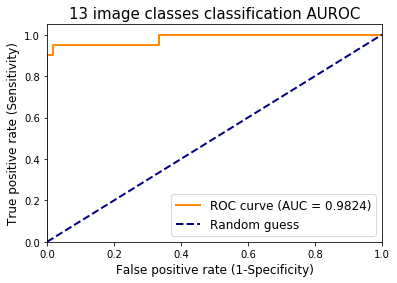

In [23]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', 
         lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (1-Specificity)', fontsize=12)
plt.ylabel('True positive rate (Sensitivity)', fontsize=12)
plt.title('13 image classes classification AUROC', fontsize=15)
plt.legend(loc="lower right", fontsize=12)

fig = plt.gcf()
plt.show()

In [33]:
# 테스트 데이터로 평가하기
score = model.evaluate(x_test, y_test, verbose=1)
print('loss=', score[0])
print('accuracy=', score[1])

NameError: name 'model' is not defined

In [25]:
#use model
yhat_train=model.predict(blendedImage, batch_size=4)
yhat_val=model.predict(x_val, batch_size=4)
yhat_test=model.predict(x_test, batch_size=4)
print(len(yhat_train))
print(len(yhat_val))
print(len(yhat_test))

570
80
74


In [26]:
prediction=[]
for i in yhat_train:
    prediction.append(list(i).index(i.max()))
for i in yhat_val:
    prediction.append(list(i).index(i.max()))
for i in yhat_test:
    prediction.append(list(i).index(i.max()))

In [27]:
df['prediction']=prediction

In [28]:
answercount=0
for i in range(len(df)):
    if df['label'][i]==df['prediction'][i]:
        answercount+=1

In [29]:
answercount

719

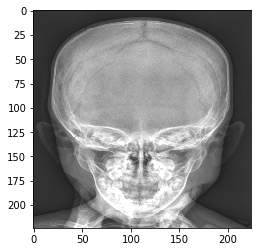

In [57]:
asdf=pydicom.filereader.dcmread(df['filename'][1]).pixel_array
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
asdf = clahe.apply(asdf)
asdf = cv2.resize(asdf, (224, 224))
asdf = cv2.cvtColor(asdf,cv2.COLOR_GRAY2RGB)
mean, std = asdf.mean(), asdf.std()
asdf =(np.clip((asdf-mean)/std, -2.0, 2.0)+2.0)/4.0
plt.imshow(asdf)

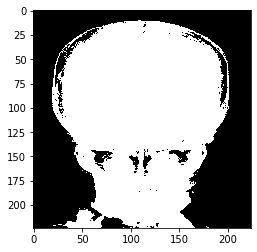

In [60]:
asdf[asdf >= 0.5] = 1
asdf[asdf < 0.5] = 0
plt.imshow(asdf)

In [ ]:
###R, L에 따라 방향성 결정해서 파일 옮겨주는 코드...

In [31]:
# For leftXray
leftXray_path = 'E:/segmentationstudy/image/oldleft' 
leftXray_list = []
for (path, dir, files) in os.walk(leftXray_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            leftXray_list.append(filePath)

In [32]:
# For rightXray
rightXray_path = 'E:/segmentationstudy/image/oldright' 
rightXray_list = []
for (path, dir, files) in os.walk(rightXray_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            rightXray_list.append(filePath)

In [33]:
leftmetadata=[]
for i in leftXray_list:
    leftmetadata.append(pydicom.dcmread(i))
rightmetadata=[]
for i in rightXray_list:
    rightmetadata.append(pydicom.dcmread(i))

In [34]:
overlayData=[]
for image in leftmetadata:
    overlay_data=image[0x6000, 0x3000].value
    rows = image[0x6000, 0x0010].value
    cols = image[0x6000, 0x0011].value
    btmp = np.frombuffer(overlay_data, dtype=np.uint8)
    btmp = np.unpackbits(btmp)
    btmp = btmp[:rows*cols]
    btmp = np.reshape(btmp, (rows, cols))
    btmp = cv2.resize(btmp, (224, 224))
    overlayData.append(btmp)
overlayData=np.array(overlayData)

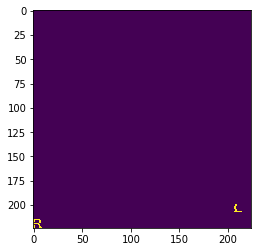

In [73]:
i=18
plt.imshow(overlayData[i])

In [72]:
shutil.copy(leftXray_list[i], leftXray_list[i].replace('oldleft', 'left'))

'E:/segmentationstudy/image/left/22429470003.dcm'

In [30]:
shutil.copy(leftXray_list[i], leftXray_list[i].replace('oldleft', 'right'))

'E:/segmentationstudy/image/left/07142910001.dcm'

In [75]:
leftXray_list[18]

'E:/segmentationstudy/image/oldleft/22457210001.dcm'